In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from textstat.textstat import *
import re
import nltk
nltk.download('vader_lexicon')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\1408\AppData\Roaming\nltk_data...


In [2]:
tokenizer = nltk.RegexpTokenizer(r"\w+")
lemmatizer = nltk.WordNetLemmatizer()

In [3]:
type_of_content = "filtered"

df_consp = pd.read_csv(f'./data/conspiracy_{type_of_content}.csv')
df_consp['label'] = 0

In [4]:
subreddit_control = "ukraine"
df_control = pd.read_csv(f'./data/{subreddit_control}_{type_of_content}.csv')
df_control['label'] = 1
df_control
df = pd.concat([df_consp, df_control], axis=0)


In [13]:
submissions = df.title.apply(str).values

In [14]:
def preprocessing(text):
    text = str(text)
    text = text.lower()
    return re.sub(r"(@\[A-Za-z0-9]+)|(\w+:\/\/\S+)|^&gt;","",text)

def tokenize(text):
    text = re.sub(r"[^0-9A-Za-z' \t]","",text)
    text = tokenizer.tokenize(text)
    text = [lemmatizer.lemmatize(word, pos="v") for word in text]
    return text



In [15]:
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocessing,
            tokenizer=tokenize,
            stop_words=nltk.corpus.stopwords.words('english'),
            ngram_range=(1,2),
            min_df=5)
tfidf = tfidf_vectorizer.fit_transform(submissions).toarray()


c:\Users\1408\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['win'] not in stop_words.
  warnings.warn(


In [16]:
SentimentAnalyzer = SentimentIntensityAnalyzer()
sentiments = []
for comment in submissions:
    sentiment = SentimentAnalyzer.polarity_scores(comment)
    sentiments.append([sentiment['pos'], sentiment['neg'], sentiment['neu']])



In [17]:
reddit_features = df[['num_comments', 'score']].to_numpy()
reddit_features

array([[ 12,   6],
       [  0,   1],
       [ 16,  10],
       ...,
       [ 58, 182],
       [  0,   1],
       [ 27,   0]], dtype=int64)

In [18]:
features = np.concatenate([tfidf, reddit_features, sentiments], axis=1)
#features = np.concatenate([tfidf, sentiments], axis=1)

features.shape

(29446, 9368)

In [19]:
X = pd.DataFrame(features)
y = df['label'].values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced').fit(X_train, y_train)
#class_weight penalty='l2' multi_class='ovr', , C=0.01

y_predict = model.predict(X_test)
rep = classification_report(y_test, y_predict)

print(rep)


              precision    recall  f1-score   support

           0       0.45      0.74      0.56       738
           1       0.96      0.87      0.91      5152

    accuracy                           0.86      5890
   macro avg       0.71      0.81      0.74      5890
weighted avg       0.90      0.86      0.87      5890



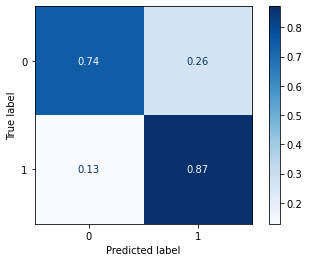

In [25]:
conf_matrix = confusion_matrix(y_test, y_predict, normalize='true')
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot(cmap='Blues')
plt.savefig(f"./images/model/{subreddit_control}_{type_of_content}.png")

results 93 83 mit pushshift